<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [1.0 Getting Started with Pyomo](https://ndcbe.github.io/CBE60499/01.00-Pyomo-Introduction.html) | [Contents](toc.html) | [1.2 Pyomo Mini-Project: Receding Horizon Stochastic Control](https://ndcbe.github.io/CBE60499/01.02-Pyomo-Mini-Project.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.01-Pyomo-Nuts-and-Bolts.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/01.01-Pyomo-Nuts-and-Bolts.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [2]:
# IMPORT DATA FILES USED BY THIS NOTEBOOK
import os,  requests

file_links = [("data/Prices_DAM_ALTA2G_7_B1.csv", "https://ndcbe.github.io/CBE60499/data/Prices_DAM_ALTA2G_7_B1.csv")]

# This cell has been added by nbpages. Run this cell to download data files required for this notebook.

for filepath, fileurl in file_links:
    stem, filename = os.path.split(filepath)
    if stem:
        if not os.path.exists(stem):
            os.mkdir(stem)
    if not os.path.isfile(filepath):
        with open(filepath, 'wb') as f:
            response = requests.get(fileurl)
            f.write(response.content)


# 1.1 60 Minutes to Pyomo: An Energy Storage Model Predictive Control Example

In [3]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.install_glpk()
    helper.download_data(['Prices_DAM_ALTA2G_7_B1.csv'])
    helper.download_figures(['battery.png','pyomo-table-4.1.png',
                            'pyomo-table-4.2.png','pyomo-table-4.3.png',
                            'pyomo-table-4.4.png','pyomo-table-4.6.png'])

In [5]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

## 1.1.1 Problem Setup

### 1.1.1.1 Background

In many regions of the world, including the US, electricity generation is scheduled through wholesale electricity markets. Individual generators (resources) transmit information about their operating costs and constraints to the market via a bid. The market operator then solves an optimization problem (e.g., the unit commitment problem) to minimize the total electricity generator cost. The market operator decides which generators to dispatch during each hour to satisfy the forecasted demand while honoring limitations for each generator (e.g., maximum ramp rate, the required time for start-up/shutdown, etc.).

![US_markets](https://www.ferc.gov/sites/default/files/2020-06/map-overview-electric.jpg)

Read more information here:
* https://www.ferc.gov/industries-data/market-assessments/electric-power-markets
* https://www.sciencedirect.com/science/article/pii/S0306261916318487

### 1.1.1.2 Pandas and Energy Prices

The CSV (comma separated value) file `Prices_DAM_ALTA2G_7_B1.csv` contains price data for a single location in California for an entire year. The prices are set every hour and have units $/MWh. We will use the package `pandas` to import and analyze the data.

In [6]:
# Load the data file
ca_data = pd.read_csv('./data/Prices_DAM_ALTA2G_7_B1.csv',names=['price'])

# Print the first 10 rows
ca_data.head()

,price
0,36.757
1,34.924
2,33.389
3,32.035
4,33.694


Next we can calculate summary statistics:

In [7]:
ca_data.describe()

,price
count,8760.000000
mean,32.516994
std,9.723477
min,-2.128700
25%,26.510000
50%,30.797500
75%,37.544750
max,116.340000


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: What are 2 or 3 interesting observations from these summary statistics?
</div>

Next, let's visualize the data in a histogram:

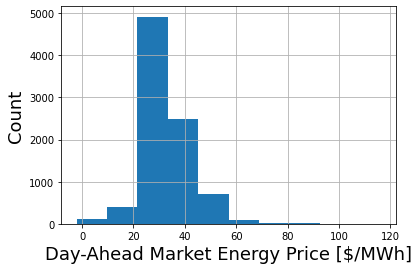

In [8]:
plt.hist(ca_data["price"])
plt.xlabel('Day-Ahead Market Energy Price [$/MWh]',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.grid(True)
plt.show()

Finaly, let's visualize the prices during the first full calendar week. The data are for calendar year 2015. For reference, January 1, 2015 was a Thursday.

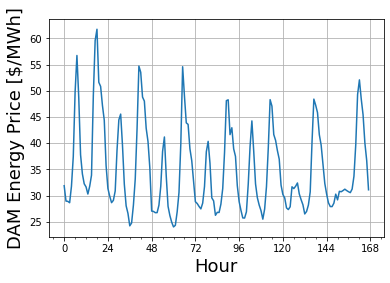

In [9]:
offset = 4 # days
number_of_days = 7
first_week = ca_data["price"].to_numpy()[(0 + offset)*24: (0 + offset + number_of_days)*24]

# Customize the major and minor ticks on the plots
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()

# Plot data
ax.plot(range(0,number_of_days*24), first_week)

# Set major ticks every 24 hours (1 day)
ax.xaxis.set_major_locator(MultipleLocator(24))

# Set minor ticks every 6 hours
ax.xaxis.set_minor_locator(MultipleLocator(6))

# Set labels, add grid
plt.xlabel('Hour',fontsize=18)
plt.ylabel('DAM Energy Price [$/MWh]',fontsize=18)
plt.grid(True)
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: What are 1 or 2 interesting observations from these plots?
</div>

### 1.1.1.3 Optimization Mathematical Model

*Energy (price) arbitrage* is the idea of using energy storage (e.g., a battery) to take advantage of the significant daily energy price swings. This gives rise to many analysis questions including:

*If a battery energy storage system perfectly timed it's energy purchases and sales (i.e., it could perfectly forecast the market price), how much money could it make from energy arbitrage?*

We can answer this question using mathematical/computational optimization!

Let's start by drawing a picture.

![battery-optimization](./figures/battery.png)

#### 1.1.1.3.1 Sets
Let's say we want to define our optimization problem over a 24 hour window. The day-ahead market sets the energy prices in 1-hour intervals. We'll define the set

$$\mathcal{T} = \{0, 1, ..., N\}$$

for time where $N = 24$ for a 24-hour planning horizon. For convienence, we'll also define $\mathcal{T}' := \mathcal{T} / \{0\}$, which is the original set $\mathcal{T}$ substract subset $\{0\}$.


#### 1.1.1.3.2 Variables

Next, let's identify the variables in the optimization problem:
* $E_t$, energy stored in battery at time $t$, units: MWh
* $d_t$, battery discharge power (sold to market) during time interval [t-1, t), units: MW
* $c_t$, battery charge power (purchased from the market) during time interval [t-1, t), units: MW

Notice how all of these variables are indexed by the timestep $t$. We'll write in the model $t \in \mathcal{T}'$

#### 1.1.1.3.3 Parameters

Parameters are data that are constant during the optimization problem. Here we have:
* $\pi_t$: Energy price during time interval [t-1, t), units: \$/MW
* $\eta$: Round trip efficiency, units: dimensionless
* $c_{max}$ Maximum charge power, units: MW
* $d_{max}$ Maximum discharge power, units: MW
* $E_{max}$ Maximum storage energy, units: MWh
* $E_{0}$ Energy in storage at time $t=0$, units: MWh
* $\Delta t = 1$ hour, Timestep for grid decisions and prices (fixed)

#### 1.1.1.3.4 Objective and Constraints

Finally, we'll identify the objective, which is the function to improve, and the mathematical constraints. Below is the full mathematical model for the problem:

$$
\begin{align*}
    \max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} \Delta t (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + \Delta t \left( c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}} \right), ~~ \forall ~ t \in \mathcal{T}' \\
    & E_{0} = E_{N} \\
    & 0 \leq c_{t} \leq c_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Write on paper a 1-sentence description for each equation.
</div>

### 1.1.1.4 Degree of Freedom Analysis

Before we program our model in Pyomo, it is *very important* to first perform a degree of freedom analysis. Here are the steps:
* Count the number of variables
* Count the number of equality constraints
* Degrees of freedom = number of variables subtract number of equality constraints

The degrees of freedom are the number of decisions variables that be freely manipulated by the optimizer. If there are no degrees of freedom, we ofter say the problem is square or it is a simulation problem.

For now, we will ignore inequality constraints and bounds. Later in the semester we will revisit degree of freedom analysis using some optimization theory concepts (e.g., active sets).

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Perform degree of freedom analysis.
</div>

## 1.1.2 Pyomo Modeling Components

<div style="background-color: rgba(255,0,0,0.05) ; padding: 10px; border: 1px solid darkred;"> 
<b>Important</b>: Do NOT implement an optimization model in Pyomo (or any other software) until you have written it on paper and performed degree of freedom analysis, as done above. Be sure to resolve any doubts, questions, or concerns while your model is still on paper. When applying optimization to a problem, a majority of the mistakes happen at the problem formulation step. So do not rush it!
</div>

### 1.1.2.1 Create `ConcreteModel`

We will start by creating a concrete Pyomo model. Recall, Pyomo is an object-oriented algebriac modeling language. The line below creates an instance of the ConcreteModel class.

In [11]:
m = pyo.ConcreteModel()

For those unfamilar with object-oriented programming, `m` is a container to define an optimization model. It includes a bunch of functionality to interface with different optimization solvers, perform diagnostics, and inspect the solution.

Pyomo also supports abstract models, but we will stick with concrete models this semester. See the Pyomo textbook for more details if you are curious.

### 1.1.2.2 Sets

We start by declaring a set for time. From above, recall we want to index all of the variables and constraints over the set

$$
\mathcal{T}' = \mathcal{T} / \{0\} = \{1, ..., N\}
$$

In [12]:
# Save the number of timesteps
m.N = 24

# Define the horizon set
m.HORIZON = pyo.Set(initialize=range(1,m.N+1))

Some Pyomo modelers prefer to use all capital names for sets; this is a personal preference.

### 1.1.2.3 Variables

Next, we can declare our three variables: $E_t$, $c_t$, $d_t$

In [13]:
# Charging rate [MW]
m.c = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 1), domain=pyo.NonNegativeReals)

# Discharging rate [MW]
m.d = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 1), domain=pyo.NonNegativeReals)

# Energy (state-of-charge) [MWh]
m.E = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 4), domain=pyo.NonNegativeReals)

See the table below (Hart et al., 2017) for an explanation of the arguments for `Var`:
    
![pyomo-var-arguments](./figures/pyomo-table-4.1.png)

Pyomo also supports units. Even though we are not explicitly using the feature, the units for all variables are clearly marked in the comments.

The following table (Hart et al., 2017) shows the options for the `within`/`domain` variable keyword:

![pyomo-var-domain](./figures/pyomo-table-4.2.png)


In the example above, `domain=pyo.NonNegativeReals` is not needs, as we are specifying stricker bounds. It is included above to show the syntax.

### 1.1.2.4 Parameters (Constants / Data)

The next step is to define the parameter data: $\pi_t$ (energy prices), $\eta$ (round trip efficiency) and $E_0$ (intial energy storage level).

In [14]:
# Square root of round trip efficiency
m.sqrteta = pyo.Param(initialize = pyo.sqrt(0.88))

# Energy in battery at t=0
m.E0 = pyo.Param(initialize = 2.0, mutable=True)



In [10]:
m.pprint()

1 Set Declarations
    HORIZON : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

2 Param Declarations
    E0 : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
        Key  : Value
        None :   2.0
    sqrteta : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 0.938083151964686

3 Var Declarations
    E : Size=24, Index=HORIZON
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.0 :     4 : False : False : NonNegativeReals
          2 :     0 :   0.0 :     4 : False : False : NonNegativeReals
          3 :     0 :   0.0 :     4 : False : False : NonNegativeReals
          4 :     0 :   0.0 :     4 : False : False : NonNegativeReals
          5 :     0 :   0.0 :     4 : False : False : NonNegativeReals
          6 :     0 :   0.0 

We see the `initialize` keyword is used to set the parameter value. When `mutable=True`, Pyomo builds the model such that we can easily update the parameter and resolved. Later in the notebook, we will see how this is helpful.

Below is a table (Hart et al., 2017) of options for `Param`:

    
![pyomo-param-arguments](./figures/pyomo-table-4.6.png)

Let's dig in more to the `initialize` syntax. First, let's convert the price data from pandas into a numpy array:

In [15]:
my_np_array = ca_data["price"].to_numpy()

# get the length
print("len(my_np_array) =",len(my_np_array))

len(my_np_array) = 8760


Recall, our dataset constains an entire year (which has 8760 hours). To access the first 24 hours, we use the following slice:

In [16]:
my_np_array[0:24]

array([36.757, 34.924, 33.389, 32.035, 33.694, 36.88 , 38.662, 38.975,
       35.08 , 29.979, 27.546, 25.944, 24.587, 23.788, 25.236, 30.145,
       44.622, 50.957, 59.345, 52.564, 52.819, 48.816, 46.685, 38.575])

In [17]:
len(my_np_array[0:24])

24

Initializing parameters in Pyomo can be precarious. The most fool proof strategy is to prepare a dictionary where the keys match the elements of the sets that index the parameter of interest. In our example, `m.HORIZON` contains 1, ..., 24, so we need a dictionary with the keys 1, ..., 24.

In [18]:
ca_data["price"][0:24].to_dict()

{0: 36.757,
 1: 34.924,
 2: 33.389,
 3: 32.035,
 4: 33.694,
 5: 36.88,
 6: 38.662,
 7: 38.975,
 8: 35.08,
 9: 29.979,
 10: 27.546,
 11: 25.944,
 12: 24.587,
 13: 23.788,
 14: 25.236,
 15: 30.145,
 16: 44.622,
 17: 50.957,
 18: 59.345,
 19: 52.564,
 20: 52.819,
 21: 48.816,
 22: 46.685,
 23: 38.575}

That was easy. But what if we wanted to build the optimization model using the second day of data? Let's give it a try:

In [19]:
ca_data["price"][24:48].to_dict()

{24: 37.239,
 25: 34.766,
 26: 34.645,
 27: 33.21,
 28: 35.524,
 29: 44.143,
 30: 39.231,
 31: 41.251,
 32: 36.406,
 33: 31.194,
 34: 29.695,
 35: 27.034,
 36: 26.009,
 37: 24.829,
 38: 26.168,
 39: 29.921,
 40: 44.137,
 41: 51.751,
 42: 51.652,
 43: 46.675,
 44: 45.274,
 45: 44.053,
 46: 46.779,
 47: 37.307}

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Uncomment the line below and look at the error message and read below. Then comment the line out again and rerun the notebook up to this cell.
</div>

In [20]:
# m.price = pyo.Param(m.HORIZON, initialize = ca_data["price"][24:48].to_dict(), domain=pyo.Reals)

You should get the following error:

```
ERROR: Constructing component 'price' from data=None failed: KeyError: "Index
    '25' is not valid for indexed component 'price'"
```

Why did this happen? Our dictionary started with key 25 but we tried to create a `Param` indexed over 1 through 24.

Let's say we want to build the optimization model starting for an arbitrary day. We need to extract the correct data from the pandas DataFrame and convert it to a dictionary with the correct keys. The function below does this using a simple, easy to follow approach. There is more compact "Pythonic" syntax to do this, but we will skip it for this getting started tutorial.

In [21]:
def prepare_price_data(day):
    ''' Prepare dictionary of price data
    
    Arugments:
        day: int, day to start. day = 0 is the first day
    
    Returns:
        data_dict: dictionary of price data with keys 1 to 24
        
    Notes:
        This function assumes the pandas DataFrame ca_data is in scope.
    
    '''
    
    # Create empty dictionary
    data_dict = {}
    
    # Extract data as numpy array
    data_np_array = ca_data["price"][(day)*24:24*(day+1)].to_numpy()
    
    # Loop over elements of numpy array
    for i in range(0,24):
        
        # Add element to data_dict
        data_dict[i + 1] = data_np_array[i]
        
    return data_dict

# Create input data for day 1 (i.e., January 2, 2015)
my_data_dict = prepare_price_data(1)
print(my_data_dict)

{1: 37.239, 2: 34.766, 3: 34.645, 4: 33.21, 5: 35.524, 6: 44.143, 7: 39.231, 8: 41.251, 9: 36.406, 10: 31.194, 11: 29.695, 12: 27.034, 13: 26.009, 14: 24.829, 15: 26.168, 16: 29.921, 17: 44.137, 18: 51.751, 19: 51.652, 20: 46.675, 21: 45.274, 22: 44.053, 23: 46.779, 24: 37.307}


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Confirm <tt>my_data_dict</tt> contains the correct prices for the January 2, 2015.
</div>

In [18]:
# YOUR SOLUTION HERE

array([37.239, 34.766, 34.645, 33.21 , 35.524, 44.143, 39.231, 41.251,
       36.406, 31.194, 29.695, 27.034, 26.009, 24.829, 26.168, 29.921,
       44.137, 51.751, 51.652, 46.675, 45.274, 44.053, 46.779, 37.307])

Now we are ready to define the price data parameter:

In [19]:
m.price = pyo.Param(m.HORIZON, initialize = my_data_dict, domain=pyo.Reals, mutable=True)

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Tip</b>: When initializing variables and parameters with a pandas DataFrame, always convert to dictionary and check the keys. Often incorrectly loaded data is the root cause of unexpected errors or strange results. Checking the keys while building the model helps prevent these mistakes. 
</div>

### 1.1.2.5 Objectives

Next, we will declare the objective function in Pyomo. Below are two equally valid syntax optimizations.

In [20]:
# Approach 1: Define a function and use *rule=*
def objfun(model):
    return  sum((-model.c[t] + model.d[t]) * model.price[t] for t in model.HORIZON)
m.OBJ = pyo.Objective(rule = objfun, sense = pyo.maximize)

# Approach 2: Use *expr=*
# m.OBJ = pyo.Objective(expr = sum((-model.c[t] + model.d[t]) * model.price[t] for t in model.HORIZON), 
#    sense = maximize)

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Comment out Approach 2 above and rerun the notebook. You'll get a warning message if you do not comment out Approach 1. The answer should not change.
</div>

The following table (Hart et al., 2017) summarizes the keyword arguments for `Objective`:

![pyomo-objective-arguments](./figures/pyomo-table-4.3.png)

### 1.1.2.6 Constraints

Now let's add the last model component: the constraints.

In [21]:
# Define Energy Balance constraints. [MWh] = [MW]*[1 hr]
# Note: this model assumes 1-hour timestep in price data and control actions.
def EnergyBalance(model,t):
    # First timestep
    if t == 1 :
        return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta 

    # Subsequent timesteps
    else :
        return model.E[t] == model.E[t-1]+model.c[t]*model.sqrteta-model.d[t]/model.sqrteta

m.EnergyBalance_Con = pyo.Constraint(m.HORIZON, rule = EnergyBalance)

# Enforce the amount of energy is the storage at the final time must equal
# the initial time.
# [MWh] = [MWh]
m.PeriodicBoundaryCondition = pyo.Constraint(expr=m.E0 == m.E[m.N])

Notice the above model includes detailed comments with the units for the left-hand side and right-hand side of each equation. This is strongly recommend; it is easy for units mistakes to go undetected in a complicated Pyomo model. Alternately, you can also use the units feature in Pyomo.

We see in this example a big advantage of the `rule=` approach for defininng a constraint. Inside the function `EnergyBalance` we incorporate a logical statement for how to handle the first timestep (which uses parameter `E0`).

Below is a table of keyword arguments for `Constraint`:

![pyomo-constraint-arguments](./figures/pyomo-table-4.4.png)

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Compare the two model equations above to the optimization formulation below. Notice the one-to-one corespondance between the equality constraints in the mathematical formulation (below) and calls to <tt>pyo.Constraint</tt>. Also notice the sets used to create the Pyomo model are listed next to each constraint in the mathematical model. Once you learn the Pyomo syntax, translated a mathematical model into code is easy! 
</div>

### 1.1.2.7 Printing the Model

Here is the optimization model, reproduced from above for convenience:

$$
\begin{align*}
    \max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}}, ~~ \forall ~ t \in \mathcal{T}' \\
    & E_{0} = E_{N} \\
    & 0 \leq c_{t} \leq c_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$$

Now let's see if our Pyomo model matches the optimization formulation. We will use the `pprint()` command (pretty print) to inspect the full model.

In [22]:
m.pprint()

1 Set Declarations
    HORIZON : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

3 Param Declarations
    E0 : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
        Key  : Value
        None :   2.0
    price : Size=24, Index=HORIZON, Domain=Reals, Default=None, Mutable=True
        Key : Value
          1 : 37.239
          2 : 34.766
          3 : 34.645
          4 :  33.21
          5 : 35.524
          6 : 44.143
          7 : 39.231
          8 : 41.251
          9 : 36.406
         10 : 31.194
         11 : 29.695
         12 : 27.034
         13 : 26.009
         14 : 24.829
         15 : 26.168
         16 : 29.921
         17 : 44.137
         18 : 51.751
         19 : 51.652
         20 : 46.675
         21 : 45.274
         22 : 44.053
         23 : 46.779
         24 : 37.307
    sqrteta : Size=1, 

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Does our Pyomo model match the optimization mathematical model (equations above)? How did we incorporate the inequality constraints into the Pyomo model?
</div>

### 1.1.2.8 Another Approach: Build the Model in a Function

To emphasize the tutorial nature of this example, we build the model on piece at a time above. An often preferred approach is to define a Python function that builds the model, such as the one below.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: The function below uses elements of <tt>price</tt> directly. Update the function to add the price data as a parameter in the Pyomo model. Make this parameter mutable as shown above.
</div>

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Fix any syntax errors with the function below.
</div>

In [23]:
# define a function to build model
def build_model(price,e0 = 0):
    '''
    Create optimization model for MPC

    Arguments (inputs):
        price: NumPy array with energy price timeseries
        e0: initial value for energy storage level
    
    Returns (outputs):
        my_model: Pyomo optimization model
    '''
    
    # Create a concrete Pyomo model. We'll learn more about this in a few weeks
    my_model = pyo.ConcreteModel()

    ## Define Sets

    # Number of timesteps in planning horizon
    my_model.HORIZON = pyo.Set(initialize = range(len(price)))

    ## Define Parameters

    # Square root of round trip efficiency
    my_model.sqrteta = pyo.Param(initialize = sqrt(0.88))

    # Energy in battery at t=0
    my_model.E0 = pyo.Param(initialize = e0, mutable=True)

    ## Define variables
    
    # Charging rate [MW]
    my_model.c = pyo.Var(my_model.HORIZON, initialize = 0.0, bounds=(0, 1))

    # Discharging rate [MW]
    my_model.d = pyo.Var(my_model.HORIZON, initialize = 0.0, bounds=(0, 1))

    # Energy (state-of-charge) [MWh]
    my_model.E = pyo.Var(my_model.HORIZON, initialize = 0.0, bounds=(0, 4))

    ## Define constraints
    
    # Define Energy Balance constraints. [MWh] = [MW]*[1 hr]
    # Note: this model assumes 1-hour timestep in price data and control actions.
    def EnergyBalance(model,t):
        # First timestep
        if t == 0 :
            return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta 
        
        # Subsequent timesteps
        else :
            return model.E[t] == model.E[t-1]+model.c[t]*model.sqrteta-model.d[t]/model.sqrteta
    
    my_model.EnergyBalance_Con = pyo.Constraint(my_model.HORIZON, rule = EnergyBalance)
    
    # Enforce the amount of energy is the storage at the final time must equal
    # the initial time.
    # [MWh] = [MWh]
    my_model.PeriodicBoundaryCondition = pyo.Constraint(expr=my_model.E0 == my_model.E[len(price)-1])
    
    ## Define the objective function (profit)
    # Receding horizon
    def objfun(model):
        return  sum((-model.c[t] + model.d[t]) * price[t] for t in model.HORIZON)
    my_model.OBJ = Objective(rule = objfun, sense = maximize)
    
    return my_model

## 1.1.3 Calling Optimization Solver

Now that our Pyomo model is complete, we can numerically solve the model!

### 1.1.3.1 `SolverFactory` and Solver Options

Algebraic Modeling Languages, including Pyomo, allow us to define optimization problems is a general, solver agnostic way. This means we can quickly swap between solvers.

We will start by using Ipopt. First, we will create an instance of the `SolverFactory`:

In [24]:
# Specify the solver
solver = pyo.SolverFactory('ipopt')

Next we can specify options for `ipopt` such as setting the maximum number of iterations to 50:

In [25]:
solver.options['max_iter'] = 50

Above `solver` is a `SolverFactory` objection which includes the dictionary `options` used to set solver specific options.

Finally, we are ready to solve our model!

In [26]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: max_iter=50


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:       96
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72
                     variables with only upper bounds:        0
Total number of equality constraints.................:       25
Total nu

The keyword argument `tee=True` tells the solve to dispaly its output to the screen.

### 1.1.3.2 Interpreting Ipopt Output - Verifying Degree of Freedom Analysis

Your Ipopt output should include the following:

```
Number of nonzeros in equality constraint Jacobian...:       96
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72
                     variables with only upper bounds:        0
Total number of equality constraints.................:       25
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0
```

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Compare this output to your degree of freedom analysis.
</div>

### 1.1.3.3 Try Another Solver

Let's see how easy it is to switch to another solver with Pyomo.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Create a new instance of <tt>SolverFactory</tt> by specifying <tt>'glpk'</tt> as the solver name. Then solve the Pyomo model <tt>m</tt> and store the results in <tt>results2</tt>.
</div>

In [27]:
# YOUR SOLUTION HERE

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/xy/24xvnyss36v3d8mw68tygxdw0000gp/T/tmpgl_k9y29.glpk.raw
 --wglp /var/folders/xy/24xvnyss36v3d8mw68tygxdw0000gp/T/tmphvy697ij.glpk.glp
 --cpxlp /var/folders/xy/24xvnyss36v3d8mw68tygxdw0000gp/T/tmpm8vhuqto.pyomo.lp
Reading problem data from '/var/folders/xy/24xvnyss36v3d8mw68tygxdw0000gp/T/tmpm8vhuqto.pyomo.lp'...
26 rows, 73 columns, 97 non-zeros
303 lines were read
Writing problem data to '/var/folders/xy/24xvnyss36v3d8mw68tygxdw0000gp/T/tmphvy697ij.glpk.glp'...
322 lines were written
GLPK Simplex Optimizer, v4.65
26 rows, 73 columns, 97 non-zeros
Preprocessing...
24 rows, 47 columns, 70 non-zeros
Scaling...
 A: min|aij| =  9.381e-01  max|aij| =  1.066e+00  ratio =  1.136e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 24
      0: obj =  -1.449764871e-01 inf =   3.062e+00 (2)
      5: obj =  -2.220151385e+01 inf =   0.000e+00 (0)
*    33:

Notice we used `solver2`, which is an instance of `SolverFactory` for the solver `glpk`. But we reused model `m`. This means the solver `glpk` used the solution from `ipopt` as its initial point.

## 1.1.4 Inspecting the Solution

We can inspect the entire model solution using `pprint()`.

In [28]:
m.pprint()

1 Set Declarations
    HORIZON : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

3 Param Declarations
    E0 : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
        Key  : Value
        None :   2.0
    price : Size=24, Index=HORIZON, Domain=Reals, Default=None, Mutable=True
        Key : Value
          1 : 37.239
          2 : 34.766
          3 : 34.645
          4 :  33.21
          5 : 35.524
          6 : 44.143
          7 : 39.231
          8 : 41.251
          9 : 36.406
         10 : 31.194
         11 : 29.695
         12 : 27.034
         13 : 26.009
         14 : 24.829
         15 : 26.168
         16 : 29.921
         17 : 44.137
         18 : 51.751
         19 : 51.652
         20 : 46.675
         21 : 45.274
         22 : 44.053
         23 : 46.779
         24 : 37.307
    sqrteta : Size=1, 

         12 :   0.0 : E[12] - (E[11] + 0.938083151964686*c[12] - 1.0660035817780522*d[12]) :   0.0 :   True
         13 :   0.0 : E[13] - (E[12] + 0.938083151964686*c[13] - 1.0660035817780522*d[13]) :   0.0 :   True
         14 :   0.0 : E[14] - (E[13] + 0.938083151964686*c[14] - 1.0660035817780522*d[14]) :   0.0 :   True
         15 :   0.0 : E[15] - (E[14] + 0.938083151964686*c[15] - 1.0660035817780522*d[15]) :   0.0 :   True
         16 :   0.0 : E[16] - (E[15] + 0.938083151964686*c[16] - 1.0660035817780522*d[16]) :   0.0 :   True
         17 :   0.0 : E[17] - (E[16] + 0.938083151964686*c[17] - 1.0660035817780522*d[17]) :   0.0 :   True
         18 :   0.0 : E[18] - (E[17] + 0.938083151964686*c[18] - 1.0660035817780522*d[18]) :   0.0 :   True
         19 :   0.0 : E[19] - (E[18] + 0.938083151964686*c[19] - 1.0660035817780522*d[19]) :   0.0 :   True
         20 :   0.0 : E[20] - (E[19] + 0.938083151964686*c[20] - 1.0660035817780522*d[20]) :   0.0 :   True
         21 :   0.0 : E[21] 

The solution is stored in the `value` column. This is helpful for debugging small models but tendious overwise.

### 1.1.4.1 Extracting Solution from Pyomo

A key advantage of Pyomo is that it is an Algebriac Modeling Language in Python. So let's use Python to analyze the solution! The code below extracts the values of the variables into three lists.

In [29]:
# Declare empty lists
c_control = []
d_control = []
E_control = []
t = []

# Loop over elements of HORIZON set.
for i in m.HORIZON:
    
    t.append(pyo.value(i))
    
    # Use value( ) function to extract the solution for each varliable and append to the results lists
    c_control.append(pyo.value(m.c[i]))
    
    # Adding negative sign to discharge for plotting
    d_control.append(-pyo.value(m.d[i]))
    E_control.append(pyo.value(m.E[i]))

In [30]:
print(c_control)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.264014327112209, 1.0, 1.0, 1.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [31]:
print(d_control)

[-0.0, -0.0, -0.0, -0.0, -0.0, -1.0, -0.756166303929372, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -1.0, -1.0, -0.0, -0.0, -0.0, -0.756166303929372, -0.0]


In [32]:
print(E_control)

[2.0, 2.0, 2.0, 2.93808315196469, 2.93808315196469, 1.87207957018663, 1.06600358177805, 0.0, 0.0, 0.0, 0.247667392141256, 1.18575054410594, 2.12383369607063, 3.06191684803531, 4.0, 4.0, 4.0, 2.93399641822195, 1.8679928364439, 1.8679928364439, 1.8679928364439, 1.8679928364439, 1.06191684803531, 2.0]


### 1.1.4.2 Visualizing the Solution

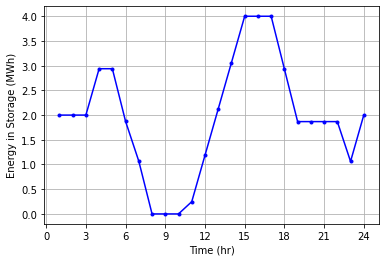

In [33]:
# Plot the state of charge (E)
plt.figure()

# add E0
t_ = [0] + t

E_control_ = [pyo.value(m.E0)] + E_control

plt.plot(t,E_control,'b.-')
plt.xlabel('Time (hr)')
plt.ylabel('Energy in Storage (MWh)')
plt.xticks(range(0,25,3))
plt.grid(True)
plt.show()

# This should NOT be a stair plot as energy is the integral of power. The graph below is reasonable.

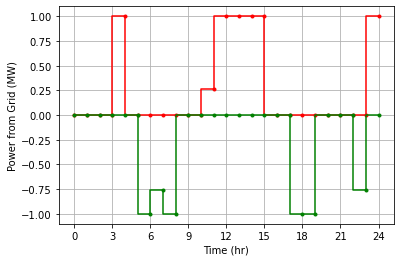

In [34]:
# Plot the charging and discharging rates
plt.figure()

# double up first data point to make the step plot
c_control_ = [c_control[0]] + c_control
d_control_ = [d_control[0]] + d_control

plt.step(t_,c_control_,'r.-',where='pre')
plt.step(t_,d_control_,'g.-',where='pre')
plt.xlabel('Time (hr)')
plt.ylabel('Power from Grid (MW)')
plt.xticks(range(0,25,3))
plt.grid(True)
plt.show()


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Improve the formatting of the plots using the code from the top of the notebook (pandas section).
</div>

### 1.1.4.3 Accessing Dual Variables

Coming Soon! This will get updated sometime during the first month. We will revisit dual variables later in the semester after introducing some optimization theory concepts.

## 1.1.5 Extension: Receding Horizon Stochastic Control

In the above notebook, we considered model predictive control (MPC) of a battery energy storage system interacting with the electricity market. In essence, we posed an optimization problem:

*Given a forecasting for energy prices, what charging and discharging strategy maximizes net market revenue?*

For homework, you will consider two modifications to make the example more realistic:
1. Receding horizon control
2. Uncertainty

The goal is to help you develop Python programming skills.

### Background: Receding Horizon Control

*Please ask questions during class.*

Nomenclature: Let $u^*_{i}$ represent the optimal control action from time $t=i$ to $t=i+1$. For the battery system, $u_{i} = [c_i, d_i]^{T}$ (charging and discharging).

Algorithm:
1. Consider time $t=m$. 
2. Compute the optimal control actions $u^*=[u^*_m, u^*_{m+1}, ..., u^*_{m+N-1}]^T$ from time $t=m$ until $t=N+m$ where $N$ is the length of the planning horizon. In our battery example, we considered $N = 24$.
3. Simulate the system for one timestep using control action $u^*_{m}$.
4. (Optional). Update the system model or forecasts using new observations.
5. Step $t=m+1$ and goto Step 2.

### 1.1.5.1 Pseudocode

Pseudocode is an important planning tool for complex computer programs. The idea is to write out the code on paper or a whiteboard using generic programming syntax. As an example, consider calculating the 3rd through 10th elements of the Fibonacci sequence:

```
# Governing equation where f[i] is the ith element of the sequence
# f[i] = f[i-1] + f[i-2]

# Algorithm:

# Previous previous number in the sequence, f[i-2]
n_2prev = 1

# Previous number in the sequence, f[i-1]
n_1prev = 1

# Set counter
j = 3

while j <= 10 do:
    # Apply Fib. formula
    n = n1_prev + n2_prev
    
    # Print to screen
    print(n)
    
    # Shift history.
    # Previous number becomes previous previous number
    n2prev = n1prev
    
    # Current number becomes previous number
    n1prev = n
    
    # Increment counter
    j = j + 1
```

Here we sketched out the main algorithm (with comments!) in generic syntax. We did not worry about the correct way to write a while loop in Python. Once we figure out the algorithm we can worry about those details.

Write pseudocode for the receding horizon control example on paper or a whiteboard. Your algorithm should include the following main steps:
1. Load price data from a text file
2. Loop over timesteps. Keep track of implemented control actions (charge and discharge), battery SOC, and net revenue.
3. Make a plot of battery SOC and control actions that were actually implemented.

Scan your pseudocode as a PDF and turn in via Gradescope.

### 1.1.5.2 Receding Horizon Control

Implement your pseudocode in Python. Hint: reuse code from the in class example. How can you exploit that price is a mutable paramter in the model?

Perform receding horizon control for the first 5 days in January 2015. Make a plot to show the implemented control action.

### 1.1.5.3 Uncertainty
Generate white noise with mean zero and standard deviation 5 $/MWh using `np.random.normal()` and add this to the price forecast. Calculate how much less revenue you make with price uncertainty compared to the perfect information case (Part B). *Hint:* Each time you run the simulation, you will get a different answer.

## 1.1.6 References

All tables are from Chapter 4 of Hart, W. E., Laird, C. D., Watson, J. P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). *Pyomo-Optimization Modeling in Python* (Vol. 67). Berlin: Springer. https://www.springer.com/gp/book/9783319588193

<!--NAVIGATION-->
< [1.0 Getting Started with Pyomo](https://ndcbe.github.io/CBE60499/01.00-Pyomo-Introduction.html) | [Contents](toc.html) | [1.2 Pyomo Mini-Project: Receding Horizon Stochastic Control](https://ndcbe.github.io/CBE60499/01.02-Pyomo-Mini-Project.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.01-Pyomo-Nuts-and-Bolts.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/01.01-Pyomo-Nuts-and-Bolts.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>